# Setup

**Use Conda**

While in the folder containing this notebook:
`conda env create -f rapidsc.yml`

Navigate back to where you want to clone the `scflow` repository (I recommend home)
`cd`

Clone `scflow` from GitHub.
`git clone git@github.com:easlinger/scflow.git`

Navigate to the folder where `scflow` is:
`pip install .`

`pip install senepy`

---

**Use Docker**

Make sure you have Docker installed and are in the user group (`sudo usermod -aG docker $USER` then `newgrp docker`)

1. **Pull `rapids-singlecell` Docker image and clone `scflow` from GitHub.**

`sudo docker pull ghcr.io/scverse/rapids_singlecell:latest`
`git clone git@github.com:easlinger/scflow.git`

2. **Navigate to and build the Dockerfile in this local folder** (parent directory of this notebook). Replace `/home/easlinger/AWG/ADBR/senescence` below with the path to your local folder (parent directory of this notebook).

`cd /home/easlinger/AWG/ADBR/senescence`

`sudo docker build -t senescence-image ~/AWG/ADBR/senescence`

3. **Run the Docker container.** Replace `/home/easlinger/AWG/ADBR/senescence` below with the path to your local folder (parent directory of this notebook) and `/home/easlinger/scflow` with the path to `scflow` copied from GitHub.

```
sudo docker run --rm -it \
  --runtime=nvidia --gpus all \
  -p 8888:8888 \
  -v /home/easlinger/senescence:/home/jovyan/work \
  -v /home/easlinger/scflow:/opt/scflow \
  senescence-image \
  jupyter lab \
    --ip=0.0.0.0 \
    --no-browser \
    --NotebookApp.token='' \
    --NotebookApp.password='' \
    --allow-root \
    --NotebookApp.allow_origin='*'
```

4. Inside the container:
5. 
```
pip install -e /opt/scflow  # install your local package in editable mode
python -m ipykernel install --user --name senescence-kernel
jupyter notebook --ip=0.0.0.0 --port=8888 --allow-root --no-browser
```

---

**For NVIDIA Drivers (Linux)**

```
sudo apt update
sudo apt install -y build-essential dkms

sudo apt install -y wget
wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/cuda-ubuntu2204.pin
sudo mv cuda-ubuntu2204.pin /etc/apt/preferences.d/cuda-repository-pin-600
sudo apt-key adv --fetch-keys https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/3bf863cc.pub
sudo add-apt-repository "deb https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/ /"

sudo apt update
sudo apt install -y cuda
```

---


## Load Individual Sample Files

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt
import seaborn as sns
import senepy
import scanpy as sc
import pandas as pd
import numpy as np
import scflow

pd.set_option("display.max_rows", 300)  # or None for unlimited rows


superdirec = "/home/easlinger/data"

overwrite = True  # overwrite object?
batches = ["OSD-612", "OSD-613"]

col_batch, col_sample = "batch" if len(batches) > 1 else None, "sample"
col_group = "Group"  # age &/or space flight
if len(batches) == 1:
    col_batch = col_group  # use group as batch if just one OSDR dataset

direcs = [os.path.join(superdirec, i) for i in batches]
metadata = [pd.read_csv(os.path.join(
    superdirec, f"{i}_metadata_{i}-ISA/s_{i}.txt"), sep=None,
                        engine="python").set_index("Source Name").rename_axis(
                            col_sample) for i in batches]  # list of metadata
for u in np.arange(len(metadata)):
    metadata[u] = metadata[u].join(metadata[u].apply(
        lambda x: x["Factor Value[Spaceflight]"] + str(
            " | " + str(x["Factor Value[Age]"]) if (
                "Factor Value[Age]" in metadata[u].columns and len(
                    metadata[u]["Factor Value[Age]"].unique()) > 1) else ""),
        axis=1).to_frame(col_group))  # add space flight (x age if applicable)


adatas, files = {}, {}
for u, d in enumerate(direcs):
    for x in [i for i in os.listdir(d) if os.path.isdir(os.path.join(d, i))]:
        ddd = [os.path.join(d, x, i) for i in os.listdir(os.path.join(d, x))]
        if len(ddd) > 1:
            raise ValueError(f"More than one file: {ddd}")
        # ddd = os.listdir(os.path.join(d, x, ddd[0]))
        # if len(os.listdir(ddd)) > 1:
        #     raise ValueError(f"More than one file: {os.listdir(ddd)}")
        sample = os.path.basename(os.path.join(d, x, ddd[0]))
        files[sample] = os.path.join(os.path.join(d, x, ddd[0]),
                                     "filtered_feature_bc_matrix.h5")
        adatas[sample] = sc.read_10x_h5(files[sample])
        if col_batch:
            adatas[sample].obs.loc[:, col_batch] = batches[u]
        adatas[sample].obs.loc[:, col_sample] = sample
        adatas[sample].obs.loc[:, "age"] = "Old" if "OLD" in os.path.basename(
            ddd[0]) else "Young" if "YNG" in os.path.basename(
                ddd[0]) else np.nan  # specific to OSD-613
        samp_metadata = metadata[u].loc[sample] if (
            sample in metadata[u].index.values) else metadata[u].set_index(
                "Sample Name").loc[sample]
        for v in samp_metadata.index.values:
            adatas[sample].obs.loc[:, v] = samp_metadata.loc[v]

/home/easlinger/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'RR10_BRN_GC_WT_G5': '/home/easlinger/data/OSD-612/RR10_BRN_GC_WT_G5-20250307T234232Z-001/RR10_BRN_GC_WT_G5/filtered_feature_bc_matrix.h5',
 'RR10_BRN_FLT_WT_F1': '/home/easlinger/data/OSD-612/RR10_BRN_FLT_WT_F1-20250307T231611Z-001/RR10_BRN_FLT_WT_F1/filtered_feature_bc_matrix.h5',
 'RR10_BRN_GC_WT_G1': '/home/easlinger/data/OSD-612/RR10_BRN_GC_WT_G1-20250307T210200Z-001/RR10_BRN_GC_WT_G1/filtered_feature_bc_matrix.h5',
 'RR10_BRN_GC_WT_G9': '/home/easlinger/data/OSD-612/RR10_BRN_GC_WT_G9-20250307T234621Z-001/RR10_BRN_GC_WT_G9/filtered_feature_bc_matrix.h5',
 'RR10_BRN_FLT_WT_F3': '/home/easlinger/data/OSD-612/RR10_BRN_FLT_WT_F3-20250307T205407Z-001/RR10_BRN_FLT_WT_F3/filtered_feature_bc_matrix.h5',
 'RR10_BRN_GC_WT_G3': '/home/easlinger/data/OSD-612/RR10_BRN_GC_WT_G3-20250307T235702Z-001/RR10_BRN_GC_WT_G3/filtered_feature_bc_matrix.h5',
 'RR10_BRN_FLT_WT_F7': '/home/easlinger/data/OSD-612/RR10_BRN_FLT_WT_F7-20250307T235407Z-001/RR10_BRN_FLT_WT_F7/filtered_feature_bc_matrix.h5',
 'RR

# QC

## Perform Sample-Specific QC

Metric                                                    count          mean  \
sample                       batch   Variable                                   
RR10_BRN_FLT_WT_F1           OSD-612 n_cells_by_counts  56748.0    397.789526   
                                     n_genes_by_counts  11879.0   1900.308107   
                                     pct_counts_mt      11879.0      0.895369   
                                     total_counts       11879.0   4297.867676   
RR10_BRN_FLT_WT_F3           OSD-612 n_cells_by_counts  56748.0    383.778547   
                                     n_genes_by_counts  12875.0   1691.546796   
                                     pct_counts_mt      12875.0      3.765980   
                                     total_counts       12875.0   3582.872803   
RR10_BRN_FLT_WT_F5           OSD-612 n_cells_by_counts  56748.0     94.430394   
                                     n_genes_by_counts   3307.0   1620.422135   
                                     pct_counts_mt       3307.0      1.510558   
                                     total_counts        3307.0   3400.054688   
RR10_BRN_FLT_WT_F7           OSD-612 n_cells_by_counts  56748.0    125.268133   
                                     n_genes_by_counts   5075.0   1400.732217   
                                     pct_counts_mt       5075.0      2.324753   
                                     total_counts        5075.0   2879.927002   
RR10_BRN_FLT_WT_F9           OSD-612 n_cells_by_counts  56748.0    102.984193   
                                     n_genes_by_counts   3562.0   1640.692588   
                                     pct_counts_mt       3562.0      2.612444   
                                     total_counts        3562.0   3590.372559   
RR10_BRN_GC_WT_G1            OSD-612 n_cells_by_counts  56748.0    240.642208   
                                     n_genes_by_counts   7937.0   1720.544790   
                                     pct_counts_mt       7937.0      1.986857   
                                     total_counts        7937.0   3587.976318   
RR10_BRN_GC_WT_G3            OSD-612 n_cells_by_counts  56748.0    377.601554   
                                     n_genes_by_counts  15280.0   1402.364725   
                                     pct_counts_mt      15280.0      2.512672   
                                     total_counts       15280.0   2801.481689   
RR10_BRN_GC_WT_G5            OSD-612 n_cells_by_counts  56748.0    123.086681   
                                     n_genes_by_counts   4231.0   1650.891751   
                                     pct_counts_mt       4231.0      2.132140   
                                     total_counts        4231.0   3510.922607   
RR10_BRN_GC_WT_G7            OSD-612 n_cells_by_counts  56748.0    110.418446   
                                     n_genes_by_counts   3926.0   1596.033113   
                                     pct_counts_mt       3926.0      2.188107   
                                     total_counts        3926.0   3352.360596   
RR10_BRN_GC_WT_G9            OSD-612 n_cells_by_counts  56748.0    181.012917   
                                     n_genes_by_counts   8496.0   1209.053790   
                                     pct_counts_mt       8496.0      2.758487   
                                     total_counts        8496.0   2292.073242   
RRRM2_BRN_FLT_ISS-T_OLD_FO14 OSD-613 n_cells_by_counts  56748.0    228.220660   
                                     n_genes_by_counts   4260.0   3040.156338   
                                     pct_counts_mt       4260.0      1.807542   
                                     total_counts        4260.0  10679.414062   
RRRM2_BRN_FLT_ISS-T_OLD_FO16 OSD-613 n_cells_by_counts  56748.0    287.753648   
                                     n_genes_by_counts   4863.0   3357.895126   
                                     pct_counts_mt       4863.0      4.391711   
                               

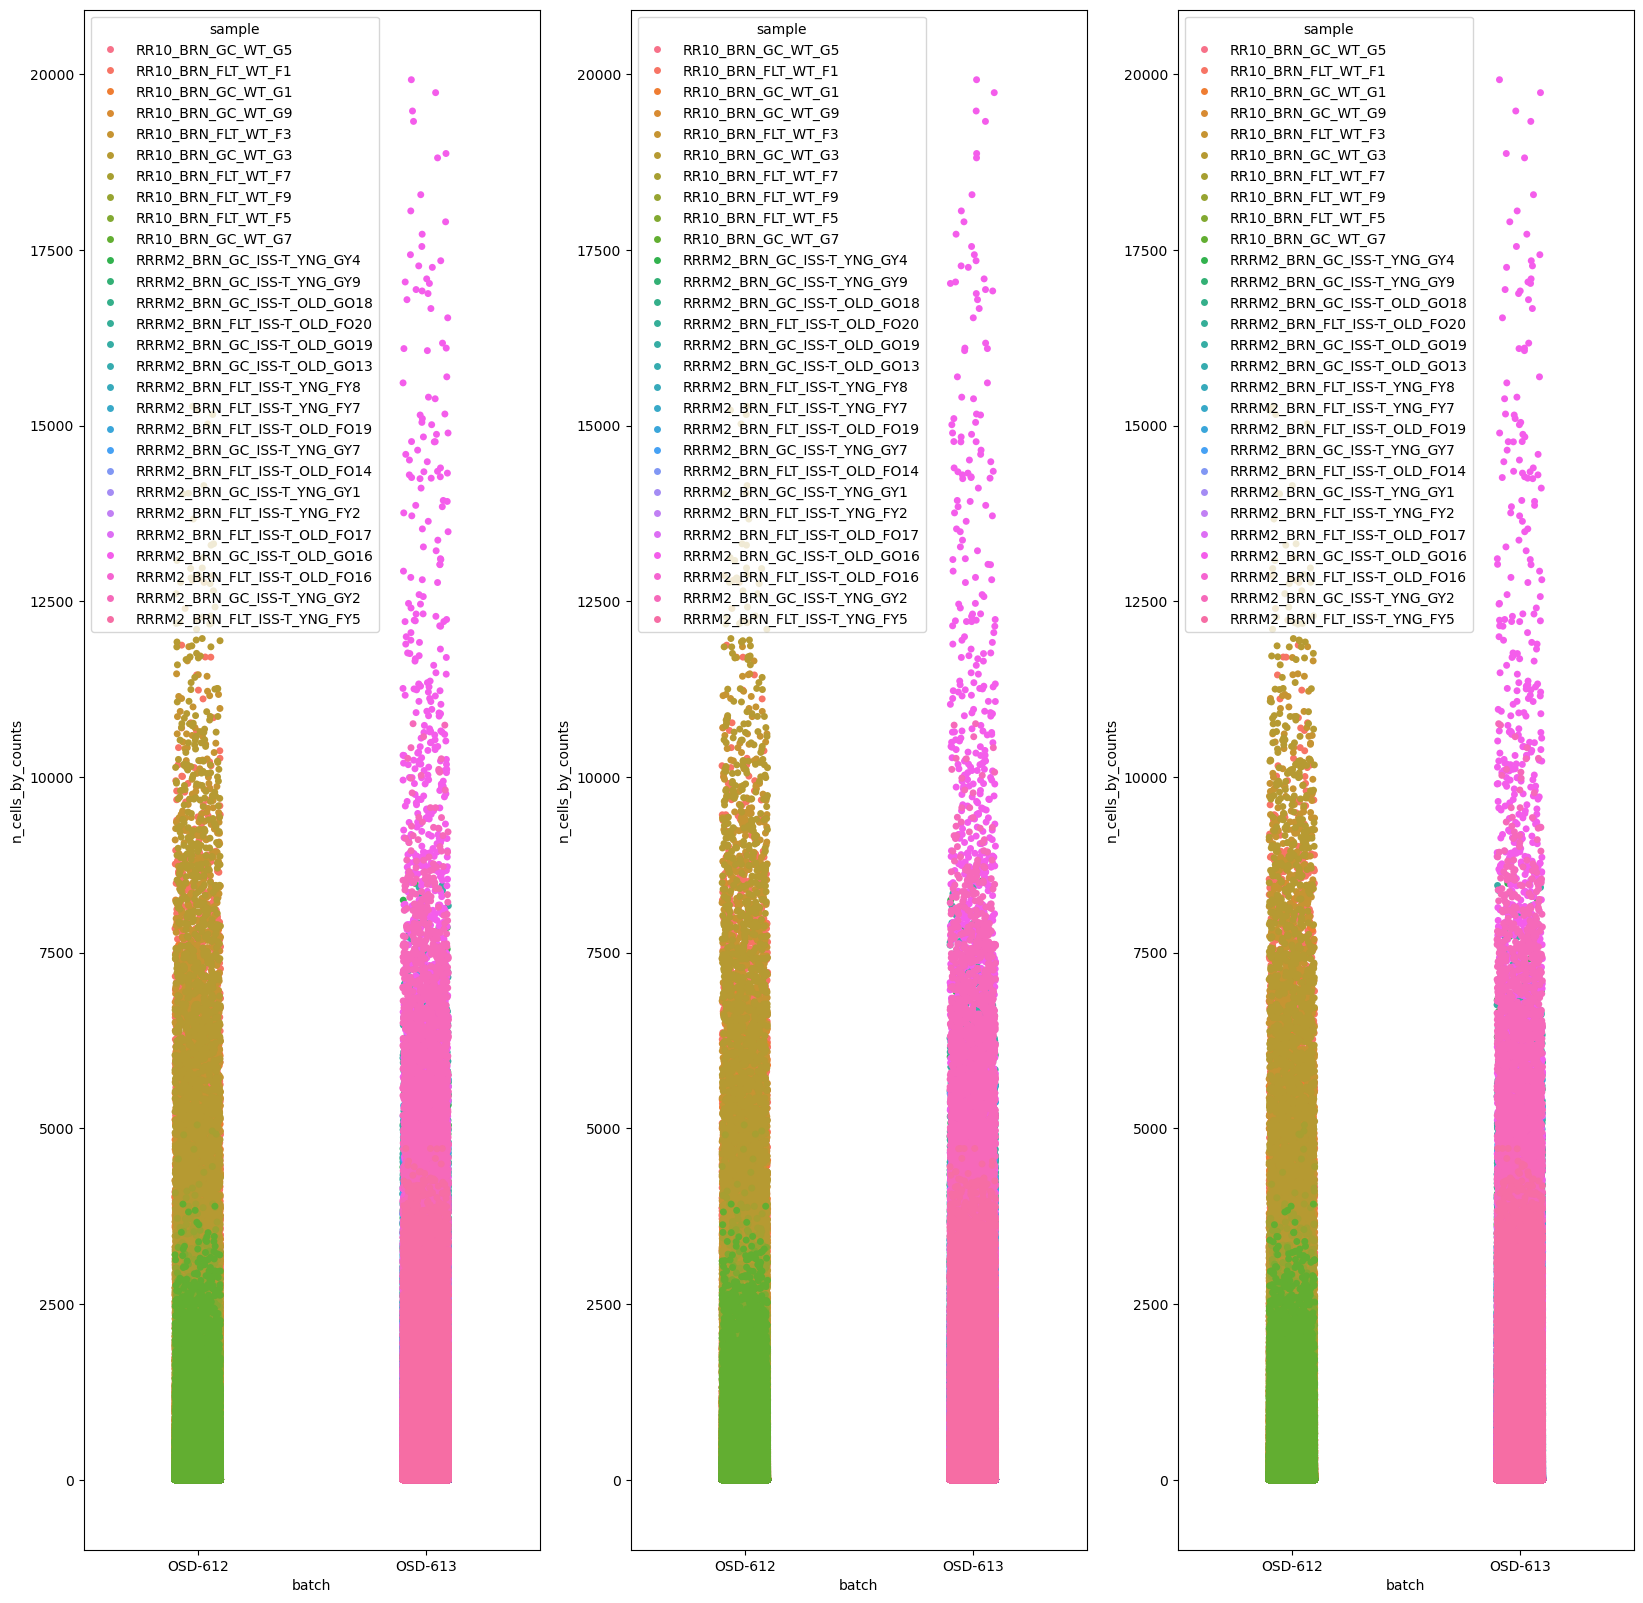

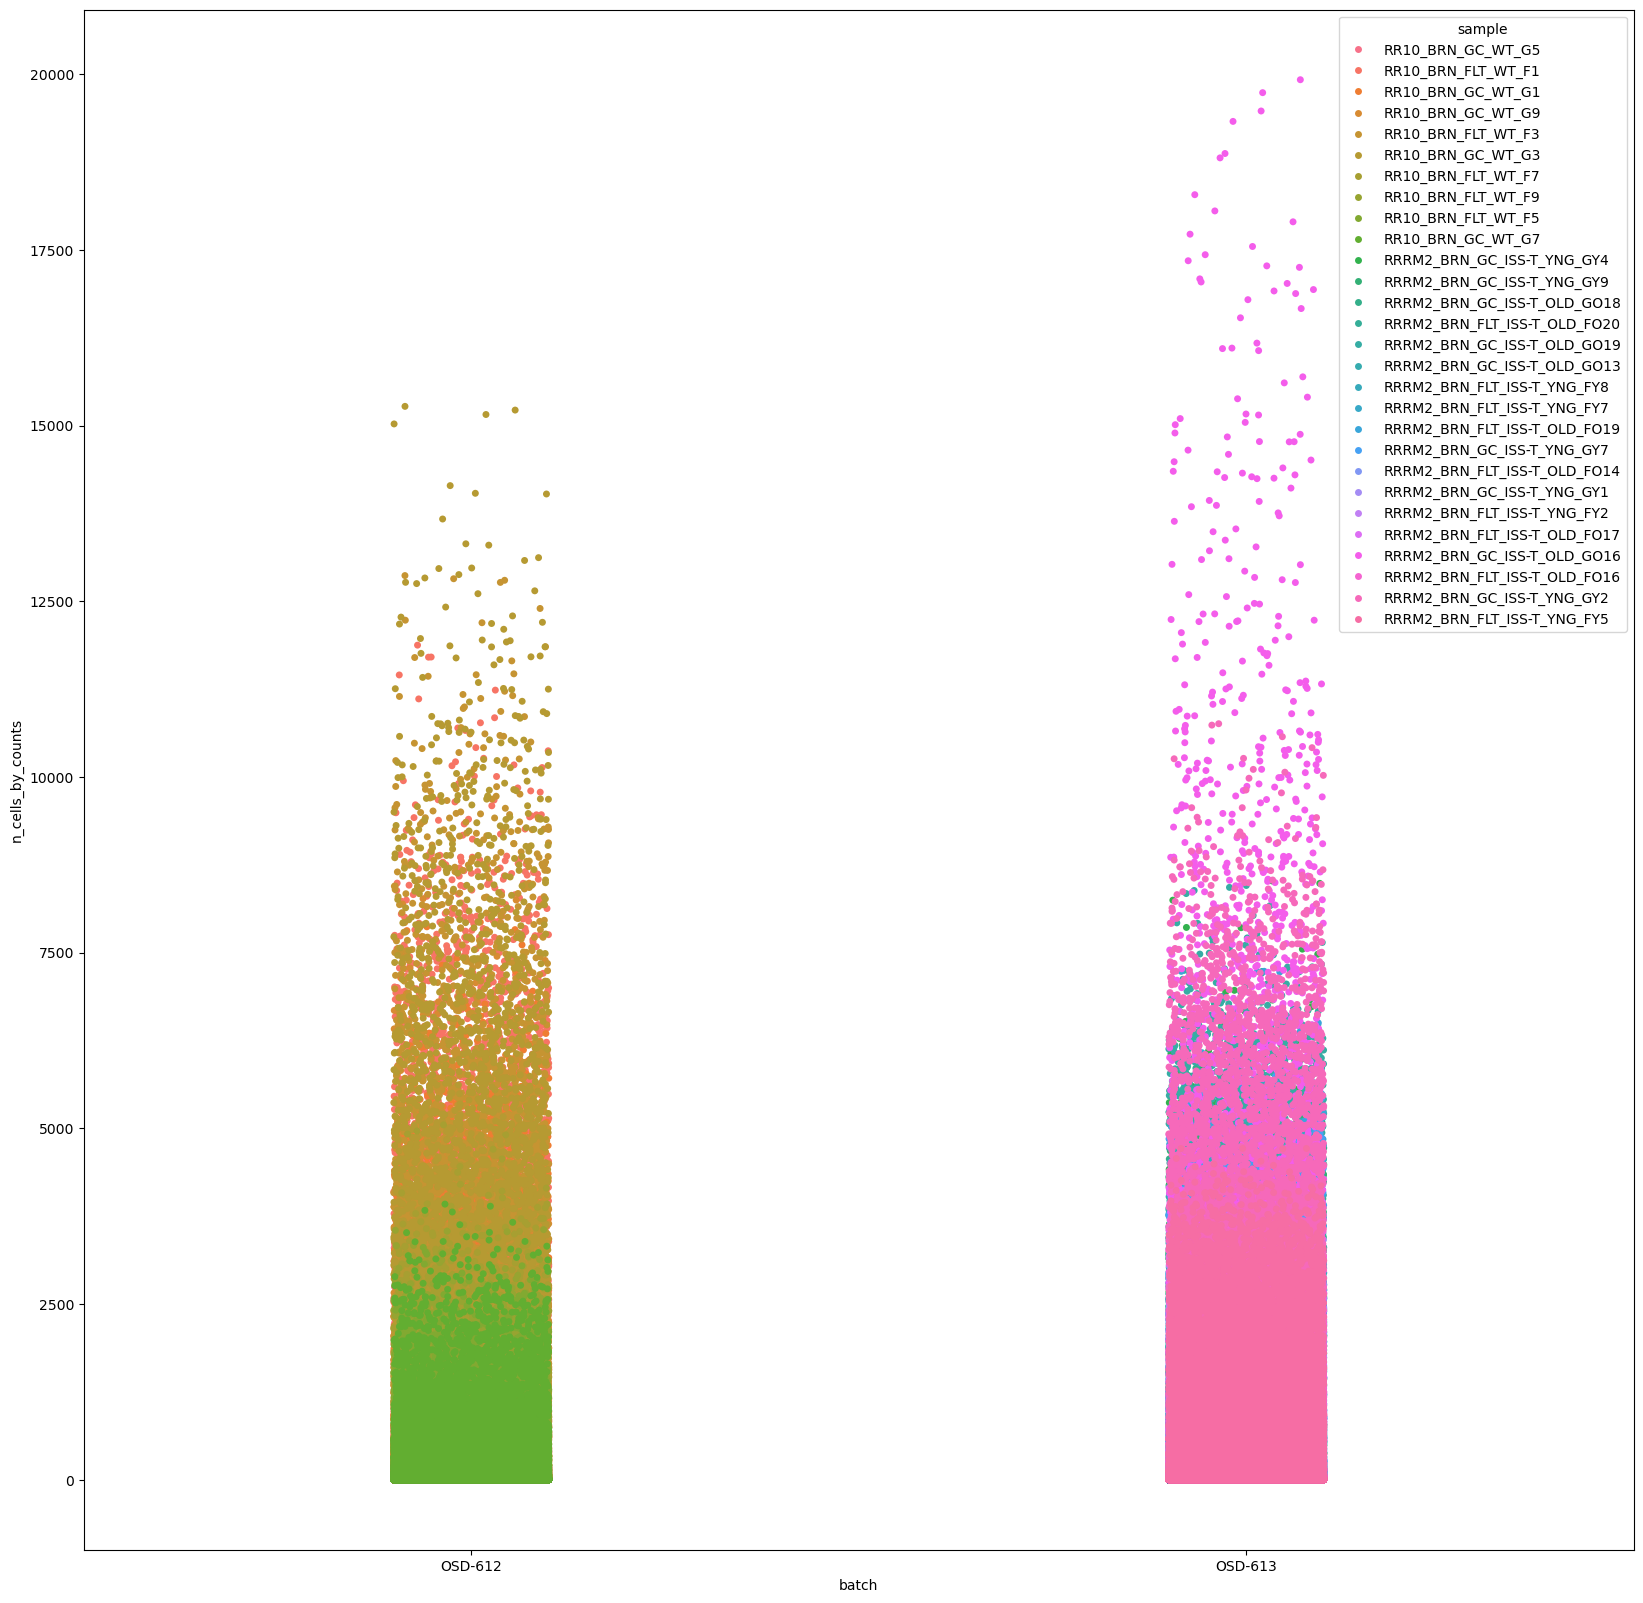

In [3]:
qcs, n_cells_by_counts, descriptives, figs = scflow.pp.perform_qc_multi(
    adatas, col_batch=col_batch, col_sample=col_sample, plot=True)
descriptives

## Auto-Detect Filtering Thresholds

Use 5th percentile (sample-specific) as minimum genes per cell, cells per gene, and total counts. Use 95th percentile as upper bound for percent mitochondrial count. 

Also include arguments to run a PCA on individual samples before integrating.

In [ ]:
kws_pp = {}
bounds_5_95 = descriptives[["5%", "95%"]].apply(lambda x: list(
    x), axis=1).unstack("Variable")  # list top/bottom 5% (~sample, variable)
for x in adatas:
    b_x = bounds_5_95.loc[x]
    kws_pp[x] = {
        "min_max_genes": [(b_x["n_genes_by_counts"] if isinstance(
            b_x["n_genes_by_counts"], list) else b_x[
                "n_genes_by_counts"].iloc[0])[0], None],
        "min_max_cells": [(b_x["n_cells_by_counts"] if isinstance(
            b_x["n_genes_by_counts"], list) else b_x[
                "n_genes_by_counts"].iloc[0])[0], None],
        "max_mt": (b_x["pct_counts_mt"] if isinstance(b_x[
            "pct_counts_mt"], list) else b_x["pct_counts_mt"].iloc[0])[1],
        "min_max_counts": [(b_x["total_counts"] if isinstance(b_x[
            "total_counts"], list) else b_x[
                "total_counts"].iloc[0])[0], None],
        "zero_center": True
    }
print("\n".join([f"{s}: {kws_pp[s]}" for s in kws_pp]))

{'RR10_BRN_GC_WT_G5': {'min_max_genes': [393.5, None], 'min_max_cells': [393.5, None], 'max_mt': 8.148360252380371, 'min_max_counts': [542.5, None], 'zero_center': True}, 'RR10_BRN_FLT_WT_F1': {'min_max_genes': [450.0, None], 'min_max_cells': [450.0, None], 'max_mt': 3.009050226211548, 'min_max_counts': [611.0, None], 'zero_center': True}, 'RR10_BRN_GC_WT_G1': {'min_max_genes': [440.0, None], 'min_max_cells': [440.0, None], 'max_mt': 7.504316139221188, 'min_max_counts': [601.0, None], 'zero_center': True}, 'RR10_BRN_GC_WT_G9': {'min_max_genes': [275.0, None], 'min_max_cells': [275.0, None], 'max_mt': 10.997422933578491, 'min_max_counts': [355.0, None], 'zero_center': True}, 'RR10_BRN_FLT_WT_F3': {'min_max_genes': [420.0, None], 'min_max_cells': [420.0, None], 'max_mt': 14.559043121337885, 'min_max_counts': [587.0, None], 'zero_center': True}, 'RR10_BRN_GC_WT_G3': {'min_max_genes': [340.0, None], 'min_max_cells': [340.0, None], 'max_mt': 9.132652330398557, 'min_max_counts': [462.9500000

# Integrate

In [ ]:
%%time

# Integrate
self = scflow.Rna(adatas, col_sample=col_sample, col_batch=col_batch,
                  kws_integrate={"kws_pp": kws_pp,
                                 "kws_cluster": dict(n_comps=20)})

# Write Files for Processed/Integrated Objects?
ppp = os.path.join("data", f"{'_'.join(batches)}_integrated.h5ad")
if overwrite is True or not os.path.exists(ppp):
    os.makedirs("data", exist_ok=True)
    self.rna.write_h5ad(ppp)
for x in adatas:
    pfp = os.path.join("data", f"{x}_integrated.h5ad")
    if overwrite is True or not os.path.exists(pfp):
        adatas[x].write_h5ad(pfp)

# Display
print(self.rna)
self.rna.X = self.rna.layers["counts"].copy()
print('hi')
# print(self.rna.var.head())
self.rna.obs




***Preprocessing RR10_BRN_GC_WT_G5: {'min_max_genes': [393.5, None], 'min_max_cells': [393.5, None], 'max_mt': 8.148360252380371, 'min_max_counts': [542.5, None], 'zero_center': True}...
***Preprocessing RR10_BRN_FLT_WT_F1: {'min_max_genes': [450.0, None], 'min_max_cells': [450.0, None], 'max_mt': 3.009050226211548, 'min_max_counts': [611.0, None], 'zero_center': True}...
***Preprocessing RR10_BRN_GC_WT_G1: {'min_max_genes': [440.0, None], 'min_max_cells': [440.0, None], 'max_mt': 7.504316139221188, 'min_max_counts': [601.0, None], 'zero_center': True}...
***Preprocessing RR10_BRN_GC_WT_G9: {'min_max_genes': [275.0, None], 'min_max_cells': [275.0, None], 'max_mt': 10.997422933578491, 'min_max_counts': [355.0, None], 'zero_center': True}...
***Preprocessing RR10_BRN_FLT_WT_F3: {'min_max_genes': [420.0, None], 'min_max_cells': [420.0, None], 'max_mt': 14.559043121337885, 'min_max_counts': [587.0, None], 'zero_center': True}...
***Preprocessing RR10_BRN_GC_WT_G3: {'min_max_genes': [340

2025-08-04 13:08:36,206 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...




***Integrating with respect to sample & batch...


2025-08-04 13:08:41,684 - harmonypy - INFO - sklearn.KMeans initialization complete.
sklearn.KMeans initialization complete.
2025-08-04 13:08:42,145 - harmonypy - INFO - Iteration 1 of 10
Iteration 1 of 10
2025-08-04 13:09:25,175 - harmonypy - INFO - Iteration 2 of 10
Iteration 2 of 10
2025-08-04 13:10:09,146 - harmonypy - INFO - Iteration 3 of 10
Iteration 3 of 10
2025-08-04 13:10:52,206 - harmonypy - INFO - Iteration 4 of 10
Iteration 4 of 10
2025-08-04 13:11:35,558 - harmonypy - INFO - Converged after 4 iterations
Converged after 4 iterations
... storing 'batch' as categorical
... storing 'age' as categorical
... storing 'batch' as categorical
... storing 'sample' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'interval' as categorical
... storing 'batch' as categorical
... storing 'sample' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'interval' as categorical
... 

AnnData object with n_obs × n_vars = 192793 × 56748
    obs: 'batch', 'sample', 'age', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'leiden'
    obsm: 'X_pca', 'X_umap', 'X_pca_harmony', 'X_pca_old'
    layers: 'counts'
hi
CPU times: user 1h 31min, sys: 32.6 s, total: 1h 31min 33s
Wall time: 6min 24s


,batch,sample,age,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,...,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,leiden
AAACAGCCAGAAACGT-1,OSD-612,RR10_BRN_GC_WT_G5,NaN,2742,7.916807,7117.0,8.870382,26.050302,34.256007,43.866798,...,177.0,5.181784,2.487003,33.0,3.526361,0.463679,0.0,0.000000,0.000000,7
AAACAGCCATTAAGTC-1,OSD-612,RR10_BRN_GC_WT_G5,NaN,2246,7.717351,4863.0,8.489616,23.524573,31.441497,41.003496,...,30.0,3.433987,0.616903,15.0,2.772589,0.308452,0.0,0.000000,0.000000,0
AAACATGCAAATGCCC-1,OSD-612,RR10_BRN_GC_WT_G5,NaN,2353,7.763871,4991.0,8.515592,24.103386,32.077740,41.474654,...,46.0,3.850148,0.921659,25.0,3.258096,0.500902,0.0,0.000000,0.000000,1
AAACATGCAAGGTATA-1,OSD-612,RR10_BRN_GC_WT_G5,NaN,2731,7.912789,6176.0,8.728588,22.765544,29.711788,38.584845,...,12.0,2.564949,0.194301,34.0,3.555348,0.550518,1.0,0.693147,0.016192,1
AAACATGCAGGTTACC-1,OSD-612,RR10_BRN_GC_WT_G5,NaN,1381,7.231287,2599.0,7.863267,27.587534,36.783378,48.249327,...,22.0,3.135494,0.846479,14.0,2.708050,0.538669,1.0,0.693147,0.038476,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTGTTCGGGCCAT-1,OSD-613,RRRM2_BRN_FLT_ISS-T_YNG_FY5,Young,3970,8.286773,9814.0,9.191668,20.613409,27.195843,35.214999,...,225.0,5.420535,2.292643,74.0,4.317488,0.754025,2.0,1.098612,0.020379,3
TTTGTGTTCTGTGCAG-1,OSD-613,RRRM2_BRN_FLT_ISS-T_YNG_FY5,Young,5886,8.680502,27623.0,10.226440,25.895087,34.029613,43.326214,...,520.0,6.255750,1.882489,111.0,4.718499,0.401839,1.0,0.693147,0.003620,16
TTTGTTGGTGTTAGCA-1,OSD-613,RRRM2_BRN_FLT_ISS-T_YNG_FY5,Young,873,6.773080,1469.0,7.293018,32.471069,40.639891,54.186521,...,88.0,4.488636,5.990470,16.0,2.833213,1.089176,0.0,0.000000,0.000000,11
TTTGTTGGTTAAGTGT-1,OSD-613,RRRM2_BRN_FLT_ISS-T_YNG_FY5,Young,3411,8.135054,9258.0,9.133351,24.195291,31.594297,40.386693,...,46.0,3.850148,0.496868,47.0,3.871201,0.507669,2.0,1.098612,0.021603,13


# Preprocessing Integrated Object

In [ ]:
self.preprocess(inplace=True, plot_qc=False,
                zero_center=True, max_value=10)

# Clustering

Perform PCA, UMAP embedding, and Leiden clustering on the integrated object

In [ ]:
%%time

self.cluster(col_celltype="leiden", resolution=0.2, min_dist=0.3,
             use_highly_variable=True)  # cluster
self.plot(kind="umap", wspace=0.3, color=[
    self._info["col_batch"], "leiden", self._info["col_sample"]])  # plot UMAP
self.find_markers()  # DEGs by cluster

# Annotate

Annotate cell types with various methods

## Examine Marker Genes

Also see plot above.

This cell looks at top markers by log2fold-change and adjusted p-value cutoffs and sorts by adjusted p-values.

In [ ]:
markers_df = self.get_markers_df(
    n_genes=3, rankby_abs=False, p_threshold=1e-5,
    log2fc_threshold=None, log2fc_threshold_abs=False)
self.plot_heat(genes=dict(markers_df.reset_index("names")["names"]),
               kind="heat")
markers_df

## Annotate by Marker Gene Overlap

In [ ]:
# marker_genes = {
#     "CD4 T cells": {"IL7R"},
#     "CD14+ Monocytes": {"CD14", "LYZ"},
#     "B cells": {"MS4A1"},
#     "CD8 T cells": {"CD8A"},
#     "NK cells": {"GNLY", "NKG7"},
#     "FCGR3A+ Monocytes": {"FCGR3A", "MS4A7"},
#     "Dendritic Cells": {"FCER1A", "CST3"},
#     "Megakaryocytes": {"PPBP"},
# }  # just an example of the format
# marker_matches = self.annotate(
#     marker_dict,
#     col_celltype="leiden", col_celltype_new="leiden_annotated_by_overlap",
#     top_n_markers=200, adj_pval_threshold=1e-5,
#     method="overlap_count", overwrite=True)
# self.rna.obs[["leiden", "leiden_annotated_by_overlap"]]

## Annotate with CellTypist

In [ ]:
%%time

# Run CellTypist
predictions = self.annotate(
    "Mouse_Whole_Brain.pkl", col_celltype="leiden",
    col_celltype_new="", majority_voting=True, min_prop=0.5, use_GPU=True)
# self.rna.obs[["leiden", "predicted_labels", "majority_voting"]]
if "majority_voting" in self.rna.obs:
    self.rna.obs.loc[:, "majority_voting_short"] = self.rna.obs[
        "majority_voting"].apply(lambda x: " ".join(x.split(" ")[1:]) if all((
            i in [str(i) for i in np.arange(0, 10)] for i in x.split(
                " ")[0])) else x)  # drop pointless #s in front of cell types

# Plot UMAPs
self.plot(kind="umap", color=["leiden", "predicted_labels"], wspace=0.3)
if "majority_voting" in self.rna.obs:
    self.plot(kind="umap", color=["leiden", "majority_voting"], wspace=0.3)

## Annotate with Map My Cells

- Make sure to run the following bash commonds after activating the conda environment used for this notebook.

- Pull [`cell_type_mapper`](https://github.com/AllenInstitute/cell_type_mapper) from GitHub (clone into your home directory): `cd && git clone git@github.com:AllenInstitute/cell_type_mapper.git`

- Navigate to the folder containing this notebook.

- Make needed directories (run while in same directory as this notebook):

```
mkdir scratch
mkdir resources
```

- Install ABC Atlas (while in same directory as this notebook): `pip install -U git+https://github.com/alleninstitute/abc_atlas_access >& scratch/junk.txt`

- Pull lookup files (while in same directory as this notebook):
```
cd resources
wget https://allen-brain-cell-atlas.s3-us-west-2.amazonaws.com/mapmycells/WMB-10X/20240831/mouse_markers_230821.json
wget https://allen-brain-cell-atlas.s3-us-west-2.amazonaws.com/mapmycells/WMB-10X/20240831/precomputed_stats_ABC_revision_230821.h5
```

Note: To use GPU + Torch, you may need to alter the file "cell_type_mapper/src/cell_type_mapper/cell_by_gene/cell_by_gene.py" line `np.where(np.logical_not(np.isfinite(data)))[0]` to read instead

```
try:
    nan_rows = np.where(
        np.logical_not(np.isfinite(data.cpu().numpy())))[0]
except Exception:
    nan_rows = np.where(np.logical_not(np.isfinite(data)))[0]
```

In [ ]:
n_processors = os.cpu_count() - 1
adata = scflow.pp.run_mapmycells(
    file_new, map_my_cells_source=map_my_cells_source,
    dir_scratch="scratch", dir_resources="resources",
    validate_output_file="scratch/tmp.h5ad",
    map_my_cells_region_keys=map_my_cells_region_keys,
    map_my_cells_cell_keys=map_my_cells_cell_keys, n_processors=n_processors)

In [ ]:
# %%time

# # Write Object & Rectify Gene Names (to EnsemblIDs)
# if overwrite is True or not os.path.exists(file_new):
#     os.makedirs("data", exist_ok=True)
#     # self.rna.X = self.rna.layers["counts"]
#     self.rna.var_names_make_unique()
#     if "ENSMUSG00000118396" in self.rna.var_names and (
#             "Iqcf3" in self.rna.var_names):
#         self.rna = self.rna[:, list(set(self.rna.var_names).difference(
#             ["ENSMUSG00000118396"]))]  # drop duplicate gene to avoid error?
#     self.rna.write_h5ad(file_new)
# else:
#     raise ValueError("Must be able to write to use My Cell Mapper")
# # self.rna.var_names = var_names_orig
# # self.rna.write_h5ad("scratch/tmp.h5ad")
# # self.rna.var_names = var_names_orig
# out_file = "scratch/tmp.h5ad"
# os.system(
#     f"python -m cell_type_mapper.cli.validate_h5ad --input_path {file_new} "
#     "--layer counts --output_json scratch/out.json "
#     f"--valid_h5ad_path {out_file}")

# # Configuration
# baseline_precomp_path = "resources/precomputed_stats_ABC_revision_230821.h5"
# baseline_marker_path = "resources/mouse_markers_230821.json"
# baseline_json_output_path = "scratch/baseline_json_mapping_output.json"
# baseline_csv_output_path = "scratch/baseline_csv_mapping_output.csv"
# baseline_mapping_config = {
#     "query_path": out_file, "tmp_dir": "scratch",
#     "extended_result_path": str(baseline_json_output_path),
#     "csv_result_path": str(baseline_csv_output_path),
#     "max_gb": 10, "cloud_safe": False, "verbose_stdout": False,
#     "type_assignment": {
#         "normalization": "raw",
#         "n_processors": n_processors,
#         "chunk_size": 10000,
#         "bootstrap_iteration": 100,
#         "bootstrap_factor": 0.5,
#         "rng_seed": 233211
#     },
#     "precomputed_stats": {"path": str(baseline_precomp_path)},
#     "query_markers": {"serialized_lookup": str(baseline_marker_path)},
#     "drop_level": None,
# }

# # Subset by Region (if Desired)
# if map_my_cells_region_keys is not None or (
#         map_my_cells_cell_keys is not None):  # subset by region/cell labels
#     abc_cache = AbcProjectCache.from_cache_dir("scratch")
#     abc_cache.load_latest_manifest()
#     # abc_cache.list_metadata_files(directory=map_my_cells_source)
#     abc_cache.get_directory_metadata(
#         directory=map_my_cells_source.split("-10X")[0] + "-taxonomy")
#     abc_cache.get_metadata_path(
#         directory=map_my_cells_source, file_name="cell_metadata")
#     taxonomy_df = abc_cache.get_metadata_dataframe(
#         directory=map_my_cells_source.split("-10X")[0] + "-taxonomy",
#         file_name="cluster_to_cluster_annotation_membership")
#     alias_to_truth = dict()
#     for cell in taxonomy_df.to_dict(orient="records"):
#         alias = cell["cluster_alias"]
#         level = cell["cluster_annotation_term_set_label"]
#         if alias not in alias_to_truth:
#             alias_to_truth[alias] = dict()
#         alias_to_truth[alias][level] = cell["cluster_annotation_term_label"]
#     cell_metadata = abc_cache.get_metadata_dataframe(
#         directory=map_my_cells_source, file_name="cell_metadata")
#     if map_my_cells_region_keys is not None:  # subset by region keys
#         cell_metadata = cell_metadata[pd.concat([
#             cell_metadata.region_of_interest_acronym == i
#             for i in map_my_cells_region_keys], axis=1).T.any()]  # subset
#     if map_my_cells_cell_keys is not None:  # subset by cell label pattern
#         ckeys = cell_metadata.feature_matrix_label.str.contains("|".join(
#             map_my_cells_cell_keys))
#         cell_metadata = cell_metadata[ckeys]
#     valid_classes = set([alias_to_truth[x]["CCN20230722_CLAS"]
#                          for x in cell_metadata.cluster_alias.values])
#     classes_to_drop = list(set([alias_to_truth[x][
#         "CCN20230722_CLAS"] for x in alias_to_truth if alias_to_truth[x][
#             "CCN20230722_CLAS"] not in valid_classes]))
#     nodes_to_drop = [("class", x) for x in classes_to_drop]
#     baseline_mapping_config.update({
#         "nodes_to_drop": nodes_to_drop,
#         "drop_level": "CCN20230722_SUPT"})
#     print("=======Nodes Being Dropped=======")
#     for pair in nodes_to_drop[:4]:
#         print(pair)

# # Run Mapper
# mapping_runner = FromSpecifiedMarkersRunner(
#     args=[], input_data=baseline_mapping_config)
# mapping_runner.run()

# # Programmatic Runner
# # config_path = "scratch/config.json"
# # with open(config_path, "w") as f:
# #     json.dump(baseline_mapping_config, f, indent=2)
# # os.system("python -m cell_type_mapper.cli.from_specified_markers "
# #           f"--input_json {config_path}")

# # Output & Clean Up
# cellmap = pd.read_csv(
#     "scratch/baseline_csv_mapping_output.csv", skiprows=4).set_index(
#         "cell_id").rename_axis(self.rna.obs.index.names)
# cellmap.columns = [f"cellmap_{i}" for i in cellmap]  # cellmap_ column prefix
# self.rna.obs = self.rna.obs.join(cellmap).loc[self.rna.obs.index]  # join
# for x in ["cellmap_class_name", "cellmap_subclass_name"]:
#     self.rna.obs.loc[:, f"{x}"] = self.rna.obs[x].apply(
#         lambda x: " ".join(x.split(" ")[1:]) if all((
#             i in [str(i) for i in np.arange(0, 10)] for i in x.split(
#                 " ")[0])) else x)  # drop pointless #s in front of cell types
# os.system(f"rm {out_file}")  # remove temporary h5ad input

# Final Write

NameError: name 'self' is not defined

In [ ]:
ppp = os.path.join("data", f"{'_'.join(batches)}_integrated.h5ad")
if overwrite is True or not os.path.exists(ppp):
    os.makedirs("data", exist_ok=True)
    self.rna.write_h5ad(ppp)